In [ ]:
'''Trains LSTM'''
import joblib
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
torch.manual_seed(1)
np.random.seed(1)

num_features = 1
num_hidden = 1
output_size = 1

#defining the model
lstm = nn.GRU(num_features, num_hidden).cuda()
output_layer = nn.Linear(num_hidden, output_size).cuda()

loss_function = nn.MSELoss()

optimizer = optim.SGD([
                {'params': lstm.parameters()},
                {'params': output_layer.parameters()}
            ], lr = 0.001)

counter = 0
loss_val = 0
while(counter<5000):
        coin_flip = np.random.binomial(1,0.5,1)

        T = np.random.randint(10,15)
        input_data = np.random.normal(0.0,0.2,T)
        if coin_flip == 1:
            input_data[:3] = 1.0 + np.random.normal(0.0,0.2,3)
            y_label = 1.0
        else:
            input_data[:3] = -1.0 + np.random.normal(0.0,0.2,3)
            y_label = 0.0
      
        optimizer.zero_grad()

        hidden = autograd.Variable(torch.zeros(1, 1, num_hidden).type(torch.cuda.FloatTensor))
        input_torchvar = autograd.Variable(torch.cuda.FloatTensor(input_data), requires_grad=True)
        output, hidden = lstm(input_torchvar.view(len(input_data), 1, -1), hidden)

        output_2 = output_layer(output[-1])
        
        loss = loss_function(F.sigmoid(output_2).view(1), autograd.Variable(torch.cuda.FloatTensor([y_label])))
        loss_val += loss.item()
        loss.backward()
        print loss
        optimizer.step()

        counter += 1
print loss_val/1000.0
loss_val = 0
#saving model
torch.save(lstm, "lstm_trained_model")
torch.save(output_layer, "output_layer_trained_model")
        

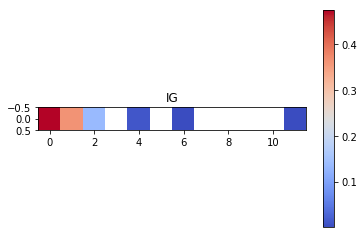

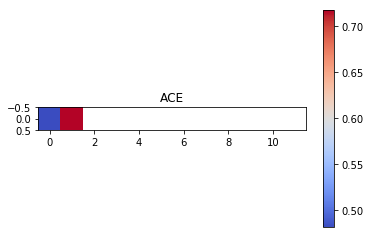

<Figure size 432x288 with 0 Axes>

In [2]:
'''Calculating attribution score via ACE and IG'''
import joblib
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
import os,csv,math, sys,joblib
import matplotlib.pyplot as plt

import sklearn.model_selection, sklearn.preprocessing, copy
from scipy.special import factorial
from sklearn.preprocessing import MinMaxScaler
import numpy as np
torch.manual_seed(1)
np.random.seed(1)

num_features = 1
num_hidden = 1
output_size = 1

lstm = torch.load("lstm_trained_model").cpu()#Loading trained model
output_layer = torch.load("output_layer_trained_model").cpu()#Loading trained model

mean_vector = [0.0]*15
baseline_expectation_do_x  =[0.5076135909386664, 0.2711588819908657, 5.629422495855416, 0.022658583459495278, 0.011492128996702376, 0.011273759561358017, 0.011215446889473235, 0.01119493013212923, 0.011193315653370518, 0.011205433818904565, 0.011231432442822552, 0.011275079370316233, 0.011344116069245506, 0.011452266314474399, 0.011623865903464321]
cov_data=np.eye(15)*0.2

input_data=np.array([ 1.07825653,  1.44238297,  0.96755107, -0.02216889,  0.28289655,
       -0.283329  ,  0.13470269, -0.15445888, -0.01877541, -0.0339548 ,
       -0.10822893,  0.10758952])

T=12

##Integrated Gradient##
lstm.zero_grad()
integrated_gradients = np.zeros(input_data.shape[0])
path_vector = np.zeros(input_data.shape[0])
final_vector = input_data
for calls_to_gradients in range(5000):
    hidden = autograd.Variable(torch.zeros(1, 1, num_hidden).type(torch.FloatTensor), requires_grad=True)
    input_torchvar = autograd.Variable(torch.FloatTensor(path_vector), requires_grad=True)
    output, hidden = lstm(input_torchvar.view(len(path_vector), 1, -1), hidden)
    output_2 = F.sigmoid(output_layer(output[-1]))

    first_grads = torch.autograd.grad(output_2, input_torchvar, retain_graph=True, create_graph=True, only_inputs=True, allow_unused=False)
    integrated_gradients += first_grads[0].data.cpu().numpy()

    path_vector += (1.0/5000)*(final_vector - np.zeros(input_data.shape[0]))
myMatrix = (integrated_gradients/5000.0)*input_data.reshape(1,-1)

myMatrix = np.ma.masked_where(myMatrix < 0.0, myMatrix)
plt.imshow(myMatrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.title("IG" )

plt.show()
plt.clf()

##ACE##
lstm.zero_grad()
input_data = np.array(input_data)
average_causal_effects = []
for t in range(len(input_data)):
    expected_value = 0.0
    expectation_do_x = []
    inp = copy.deepcopy(mean_vector)

    inp[t] = input_data[t]
    hidden = autograd.Variable(torch.zeros(1, 1, num_hidden).type(torch.FloatTensor), requires_grad=True)
    input_torchvar = autograd.Variable(torch.FloatTensor(inp), requires_grad=True)
    output, hidden = lstm(input_torchvar.view(len(inp), 1, -1), hidden)
    output_2 = F.sigmoid(output_layer(output[-1]))

    val = output_2.data.view(1).cpu().numpy()[0]

    first_grads = torch.autograd.grad(output_2, input_torchvar, retain_graph=True, create_graph=True, only_inputs=True, allow_unused=False) #as only one output

    #print causal_effect
    #calculating the hessian (selective-terms-only)
    first_grad_shape = first_grads[0].data.size()
    lower_order_grads = first_grads

    for dimension in range(len(mean_vector)):
        if dimension == t:
            continue
        grad_mask = torch.zeros(first_grad_shape)
        grad_mask[dimension] = 1.0

        higher_order_grads = torch.autograd.grad(lower_order_grads, input_torchvar, grad_outputs=grad_mask, retain_graph=True, create_graph=True, only_inputs=True, allow_unused=False) 
        higher_order_grads_array = np.array(higher_order_grads[0].data)


        temp_cov = copy.deepcopy(cov_data)
        temp_cov[dimension][t] = 0.0
        val += 0.5*np.sum(higher_order_grads_array*temp_cov[dimension])


    average_causal_effects.append(val)


average_causal_effects = np.array(average_causal_effects) - np.array(baseline_expectation_do_x)[:len(average_causal_effects)]

myMatrix = average_causal_effects.reshape(1,-1)
#print myMatrix
myMatrix = np.ma.masked_where(myMatrix < 0.0, myMatrix)
plt.imshow(myMatrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("ACE")

plt.show()
plt.clf()